In [7]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
from scipy.signal import hilbert

sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/own_code/ENF-WHU-Dataset/ENF-WHU-Dataset/H1')
sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/ENFify/sources')
sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/10s_ref/cut_10s_enf_ref')
from ENF_preprocessing import downsampling, bandpass_filter, list_files_in_directory
from ENF_frequency_phase_estimation import segmented_phase_estimation_DFT0
from Rodriguez_Audio_Authenticity import feature, Lambda, lambda_accuracy
from PDF_and_Plot import to_pdf, read_wavfile

In [2]:
def cut_out(input_file, output_file, start, end):
    os.system(f'. /home/$USER/miniforge3/etc/profile.d/conda.sh; conda activate enfify; ffmpeg -ss {start} -i {input_file} -t {end} -c copy {output_file}')

def minute_list_files_in_directory(input_dir, output_dir):
    try:
        # List all files in the directory
        files = os.listdir(input_dir)
        # Filter out directories, only keep files
        raw_files = [f for f in files if os.path.isfile(os.path.join(input_dir, f))]
        down_files = []
        files = []

        for raw in raw_files:
            down_file = output_dir + '/min_'+raw
            down_files.append(down_file)
        
        for raw in raw_files:
            files.append(input_dir + '/' + raw)

        return files, down_files

    except FileNotFoundError:
        return f"The directory {input_dir} does not exist."
    except PermissionError:
        return f"Permission denied to access {input_dir}."

In [3]:
# 10s Audio Files
N_DFT = 20_000
NUM_CYCLES = 10

cut_file = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/10s_ref/cut_10s_enf_ref/cut_min_004_ref.wav'
uncut_file = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/10s_ref/10s_enf_ref/min_004_ref.wav'

fs_cut, signal_cut = wavfile.read(cut_file)
bandpass_sig_cut = bandpass_filter(signal_cut, 1, 110 , fs_cut, 5)

fs_uncut, signal_uncut = wavfile.read(uncut_file)
bandpass_sig_uncut = bandpass_filter(signal_uncut, 1, 110, fs_uncut, 5)

F_cut = feature(segmented_phase_estimation_DFT0(bandpass_sig_cut, 400, NUM_CYCLES, N_DFT, 50))
F_uncut = feature(segmented_phase_estimation_DFT0(bandpass_sig_uncut, 400, NUM_CYCLES, N_DFT, 50))

print(F_cut)
print(F_uncut)
print(abs(F_uncut-F_cut))

-1238.8906535321228
-1418.0045527604218
179.11389922829903


In [14]:
# 10 second Audio files
input_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/10s_ref/10s_enf_ref'
output_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/10s_ref/cut_10s_enf_ref'

file_list_uncut = os.listdir(input_dir)
file_list_cut = os.listdir(output_dir)

band_down_sig = []

for wav_file in file_list_uncut:
    file_path = os.path.join(input_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.9, 50.1, fs, 4)
    band_down_sig.append(bandpass_sig)

cut_band_down_sig = []
for wav_file in file_list_cut:
    file_path = os.path.join(output_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.9, 50.1, fs, 4)
    cut_band_down_sig.append(bandpass_sig)


In [5]:
N_DFT = 20_000
NUM_CYCLES = 10
F_uncut = []
F_cut = []

for sig in tqdm(band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, fs, NUM_CYCLES, N_DFT, 50))
    F_uncut.append(F)

for sig in tqdm(cut_band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, fs, NUM_CYCLES, N_DFT, 50))
    F_cut.append(F)

100%|██████████| 130/130 [00:08<00:00, 15.06it/s]


Characterization probaility: 87.6923076923077%


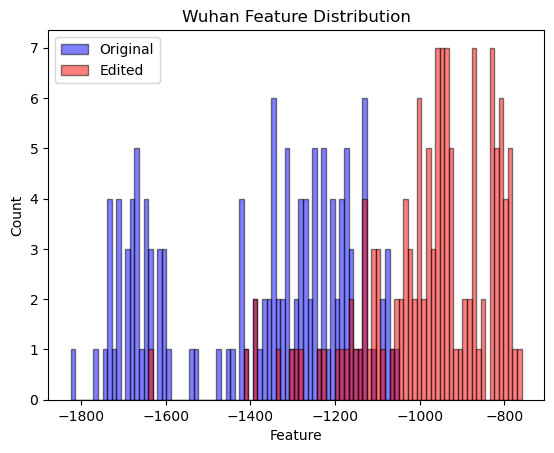

In [152]:
num_samples = len(band_down_sig)
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
features = np.concatenate([F_uncut, F_cut])

min_val = np.min(features)
max_val = np.max(features)
bins = np.linspace(min_val, max_val,100)

LAMBDA = Lambda(F_uncut, F_cut)
accuracy = lambda_accuracy(F_uncut, F_cut, LAMBDA)
print(f'Characterization probaility: {accuracy*100}%')

plt.hist(F_uncut, bins=bins,color='blue', alpha=0.5, edgecolor='black',label="Original")
plt.hist(F_cut, bins=bins, color='red', alpha=0.5, edgecolor='black', label="Edited")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title("Wuhan Feature Distribution")
plt.legend(loc="best")
plt.show()

In [9]:
# 1min Audio files
input_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/1min_ref/1min_enf_ref_data'
output_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/1min_ref/cut_1min_enf_ref_data'

file_list_uncut = os.listdir(input_dir)
file_list_cut = os.listdir(output_dir)
fs = 400

band_down_sig = []

for wav_file in file_list_uncut:
    file_path = os.path.join(input_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, 400, 5)
    band_down_sig.append(signal)

cut_band_down_sig = []
for wav_file in file_list_cut:
    file_path = os.path.join(output_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, 400, 5)
    cut_band_down_sig.append(signal)

In [164]:
N_DFT = 20_000
NUM_CYCLES = 10
F_uncut = []
F_cut = []

for sig in tqdm(band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, 400, NUM_CYCLES, N_DFT, 50))
    F_uncut.append(F)

for sig in tqdm(cut_band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, 400, NUM_CYCLES, N_DFT, 50))
    F_cut.append(F)

100%|██████████| 130/130 [00:51<00:00,  2.52it/s]


Characterization probaility: 93.07692307692308%


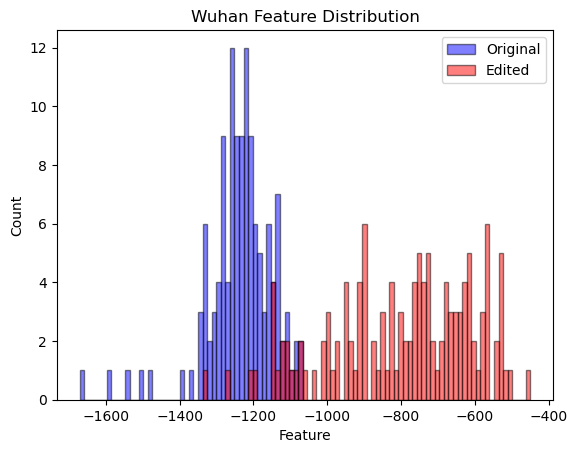

In [165]:
num_samples = len(band_down_sig)
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
features = np.concatenate([F_uncut, F_cut])

min_val = np.min(features)
max_val = np.max(features)
bins = np.linspace(min_val, max_val,100)

LAMBDA = Lambda(F_uncut, F_cut)
accuracy = lambda_accuracy(F_uncut, F_cut, LAMBDA)
print(f'Characterization probaility: {accuracy*100}%')

plt.hist(F_uncut, bins=bins,color='blue', alpha=0.5, edgecolor='black',label="Original")
plt.hist(F_cut, bins=bins, color='red', alpha=0.5, edgecolor='black', label="Edited")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title("Wuhan Feature Distribution")
plt.legend(loc="best")
plt.show()

In [3]:
# Downsample audio files
input_dir_cut = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/one_cut_ref_enf'
output_dir_cut_down = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/one_cut_dwnsmpld_ref_enf'
input_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/raw/ENF-WHU-Dataset/reference_enf'
output_dir_down = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/downsampled_ref_enf'
fs_down = 400

files, down_files =  list_files_in_directory(input_dir, output_dir_down)
cut_files, cut_down_files =  list_files_in_directory(input_dir_cut, output_dir_cut_down)

for i in range(len(files)):
    downsampling(files[i], down_files[i], fs_down)

for i in range(len(cut_files)):
    downsampling(cut_files[i], cut_down_files[i], fs_down)

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-13)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-lib

In [144]:
# One cut
dir_cut = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/one_cut_ref_enf'
dir_uncut = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/raw/ENF-WHU-Dataset/reference_enf'

file_list_uncut = os.listdir(dir_uncut)
file_list_cut = os.listdir(dir_cut)
fs_down = 400

band_down_sig = []
for wav_file in tqdm(file_list_uncut):
    file_path = os.path.join(dir_uncut, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.9, 50.1, fs, 4)
    band_down_sig.append(signal)

cut_band_down_sig = []
for wav_file in tqdm(file_list_cut):
    file_path = os.path.join(dir_cut, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.9, 50.1, fs, 4)
    cut_band_down_sig.append(signal)


100%|██████████| 130/130 [00:00<00:00, 265.33it/s]


In [145]:
N_DFT = 20_000
NUM_CYCLES = 10
F_uncut = []
F_cut = []

for sig in tqdm(band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, 400, NUM_CYCLES, N_DFT, 50))
    F_uncut.append(F)

for sig in tqdm(cut_band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, 400, NUM_CYCLES, N_DFT, 50))
    F_cut.append(F)

100%|██████████| 130/130 [09:06<00:00,  4.20s/it]


In [146]:
# Labels: 0 for class 1, 1 for class 2
num_samples = len(band_down_sig)
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
features = np.concatenate([F_uncut, F_cut])

Characterization probaility: 78.84615384615384%
-1120.57560790306


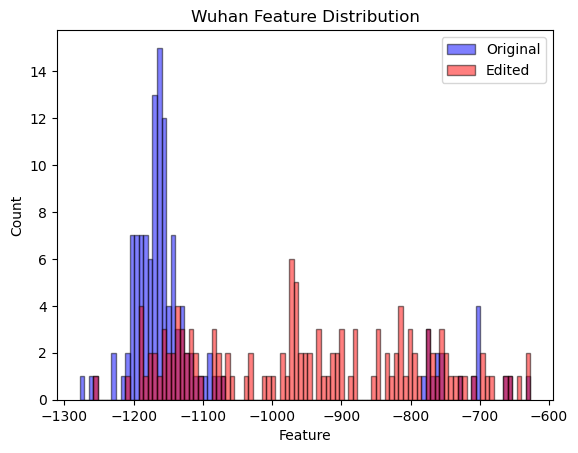

In [149]:
min_val = np.min(features)
max_val = np.max(features)
bins = np.linspace(min_val, max_val,100)

LAMBDA = Lambda(F_uncut, F_cut)
accuracy = lambda_accuracy(F_uncut, F_cut, LAMBDA)
print(f'Characterization probaility: {accuracy*100}%')

plt.hist(F_uncut, bins=bins,color='blue', alpha=0.5, edgecolor='black',label="Original")
plt.hist(F_cut, bins=bins, color='red', alpha=0.5, edgecolor='black', label="Edited")
#plt.axvline(LAMBDA, color="darkred", label=f"Lambda={LAMBDA:.3f}")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title("Wuhan Feature Distribution")
plt.legend(loc="best")
#plt.savefig("feature_WUHAN_clean_data")
plt.show()

In [ ]:
# Noisy Data
input_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/1min_ref/1min_enf_ref_data'
output_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify_Data_Synced/interim/ENF-WHU-Dataset/1min_ref/cut_1min_enf_ref_data'

file_list_uncut = os.listdir(input_dir)
file_list_cut = os.listdir(output_dir)
fs = 400

band_down_sig = []

for wav_file in file_list_uncut:
    file_path = os.path.join(input_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, 400, 5)
    band_down_sig.append(signal)

cut_band_down_sig = []
for wav_file in file_list_cut:
    file_path = os.path.join(output_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, 400, 5)
    cut_band_down_sig.append(signal)

In [1]:
array = []
len(array)

0